In [2]:
import matplotlib.pyplot as plt 
from CoolProp.CoolProp import PropsSI
import CoolProp.CoolProp as CP

import numpy as np
import pandas as pd


In [3]:
def get_pvt():
    '''Reads the vectors for pressure and temperature and the matrix for rho
       Note that the values for temperature and rho must be aligned with values in rho
       Note also for rho: One temperature for each column
                          One pressure for each row
    '''
    fn_temp    = "temperature.txt"
    fn_pres    = "pressure.txt"
    fn_rho_co2 = "rho_co2.txt"
    fn_rho_h2o = "rho_h2o.txt"
    t   = np.loadtxt(fn_temp)
    p   = np.loadtxt(fn_pres)
    rho_co2 = np.loadtxt(fn_rho_co2,delimiter=',')
    rho_h2o = np.loadtxt(fn_rho_h2o,delimiter=',')

    return t, p, rho_co2, rho_h2o

In [5]:
# atmospheric pressure
P_atm = 101325 / 1e5 # bar

RKB = 23.5
Z_sf = -312 #seafloor depth [m]

top_SF = -1217
shoe_Z = RKB-709

# reservoir aquifer pressure
aq_P = 60 # bar
aq_P = 124

# reservoir reference depth
aq_Z = -1217 # mTVDMSL

# injection pointo r base of CO2 column
base_CO2_Z = -1312 # m

# base of cement plug/barrier
barrier_Z = -562

#density brine
rho_brine = 1024 # kg/m3
rho_brine = 996 # kg/m3

#gravity acceleration
G_acc = 9.8067 # m/s2

#Create depth vector
top = 0
base = 1500

z = -np.linspace(top, base, 1+(base-top))
z = np.append(z, shoe_Z)
z = np.sort(z)
z = z[::-1]



df = pd.DataFrame(data={'depth':z})

fluid1 = 'CO2'
fluid2 = 'HEOS::CO2[0.96]&H2[0.004]&Ar[0.01]&N2[0.0084]&CH4[0.0178]'
fluid = 'CO2'

def P_aquifer(z, ref_Z, ref_P, rho = 1024, g = 9.8067):
    """
    Creates a hydrostatic gradient based on a given density that matches a reference pressure, depth point
    """

    P_offset = ref_P*1e5 + ref_Z*rho*g
    P = (-(z*g*rho) + P_offset) / 1e5
    return P

#Hydrostatic gradient



df['P_aq'] = P_aquifer(z=z, ref_P=aq_P, ref_Z=aq_Z)
df['P_hyd'] = P_atm-(df['depth']*rho_brine*G_acc)/1e5

df['Sh_min'] = df['P_hyd']
df.loc[df.depth<Z_sf, 'Sh_min'] = -(Z_sf*rho_brine*G_acc)/1e5 - 0.166*(df.loc[df.depth<Z_sf, 'depth']-Z_sf)

df


# df.loc[df.depth>barrier_Z, 'P_aq'] =  df.loc[df.depth>barrier_Z, 'P_hyd']
df.loc[df.P_aq < P_atm, 'P_aq'] = 0

#Temperature
Tgrad = 40/1000 #thermal gradient [m/degC]
T_sf = 4 #seafloor temperature [degC]

df['Temp'] = T_sf - (df['depth']-Z_sf)*Tgrad #geothermal temperature field






# hydrostatic pressure at CO2 base
base_CO2_Phyd = P_aquifer(z=base_CO2_Z, ref_P=aq_P, ref_Z=aq_Z)

# hydrostatic pressure at barrier base
barrier_Phyd = P_aquifer(z=barrier_Z, ref_P=aq_P, ref_Z=aq_Z)

#vertical height between base of CO2 and base of barrier
col_CO2_height = barrier_Z - base_CO2_Z

# CO2 column
df['CO2_h'] = df['depth'] - base_CO2_Z
df.loc[(df['CO2_h']<0) | (df['CO2_h']>col_CO2_height), 'CO2_h'] = 0

# delta z
df['dz'] = df.depth.diff()

# create a column for P
df['P'] = df['P_aq']
df['P1'] = df['P_aq']
df['P2'] = df['P_aq']

# create a column for Pcap
df['dPcap'] = 0
df['Pcap'] = 0

df['dPcap1'] = 0
df['Pcap1'] = 0

df['dPcap2'] = 0
df['Pcap2'] = 0

df['rho_g'] = 0
df['rho_g1'] = 0
df['rho_g2'] = 0
df['phase'] = ''
df['phase1'] = ''
df['phase2'] = ''





query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')


for idx, row in query.iloc[::-1].iterrows():

    col_h  = row.CO2_h
    z_val = row.depth
    dz = row.dz
    T = row.Temp
    P_aq = row.P_aq

    if col_h == 0:
        P = P_aq
        P1 = P_aq
        P2 = P_aq
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)
        rho_g1 = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid1)
        rho_g2 = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid2)

        df.loc[idx, 'rho_g'] = rho_g
        df.loc[idx, 'rho_g1'] = rho_g1
        df.loc[idx, 'rho_g2'] = rho_g2
        Pcap = 0
        Pcap1 = 0
        Pcap2 = 0

        P_previous = P
        P_previous1 = P1
        P_previous2 = P2
        
    else:
        dPcap = -((rho_brine - rho_g)*dz*G_acc)/1e5
        dPcap1 = -((rho_brine - rho_g1)*dz*G_acc)/1e5
        dPcap2 = -((rho_brine - rho_g2)*dz*G_acc)/1e5


        Pcap += dPcap
        Pcap1 += dPcap1
        Pcap2 += dPcap2

        df.loc[idx, 'dPcap'] = dPcap
        df.loc[idx, 'Pcap'] = Pcap
        df.loc[idx, 'dPcap1'] = dPcap1
        df.loc[idx, 'Pcap1'] = Pcap1
        df.loc[idx, 'dPcap2'] = dPcap2
        df.loc[idx, 'Pcap2'] = Pcap2

        P = P_aq + Pcap
        P1 = P_aq + Pcap1
        P2 = P_aq + Pcap2


        df.loc[idx, 'P'] = P
        df.loc[idx, 'P1'] = P1
        df.loc[idx, 'P2'] = P2
        
        
        
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)
        rho_g1 = PropsSI("D", "P", P1*1e5, "T", T+273.15, fluid1)
        rho_g2 = PropsSI("D", "P", P2*1e5, "T", T+273.15, fluid2)

        # try:
        #     rho_g = PropsSI("D", "P", P*1e5, "T|gas", T+273.15, fluid)
        # except:
        #     rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)


        phase = CP.PhaseSI("P", P*1e5, "T", T+273.15, fluid)
        phase1 = CP.PhaseSI("P", P1*1e5, "T", T+273.15, fluid1)
        phase2 = CP.PhaseSI("P", P2*1e5, "T", T+273.15, fluid2)

        

        df.loc[idx, 'rho_g'] = rho_g
        df.loc[idx, 'rho_g1'] = rho_g1
        df.loc[idx, 'rho_g2'] = rho_g2

        df.loc[idx, 'phase'] = phase
        df.loc[idx, 'phase1'] = phase1
        df.loc[idx, 'phase2'] = phase2

        rho_previous = rho_g
        rho_previous1 = rho_g1
        rho_previous2 = rho_g2
        
            
df = df.set_index(-df.depth)



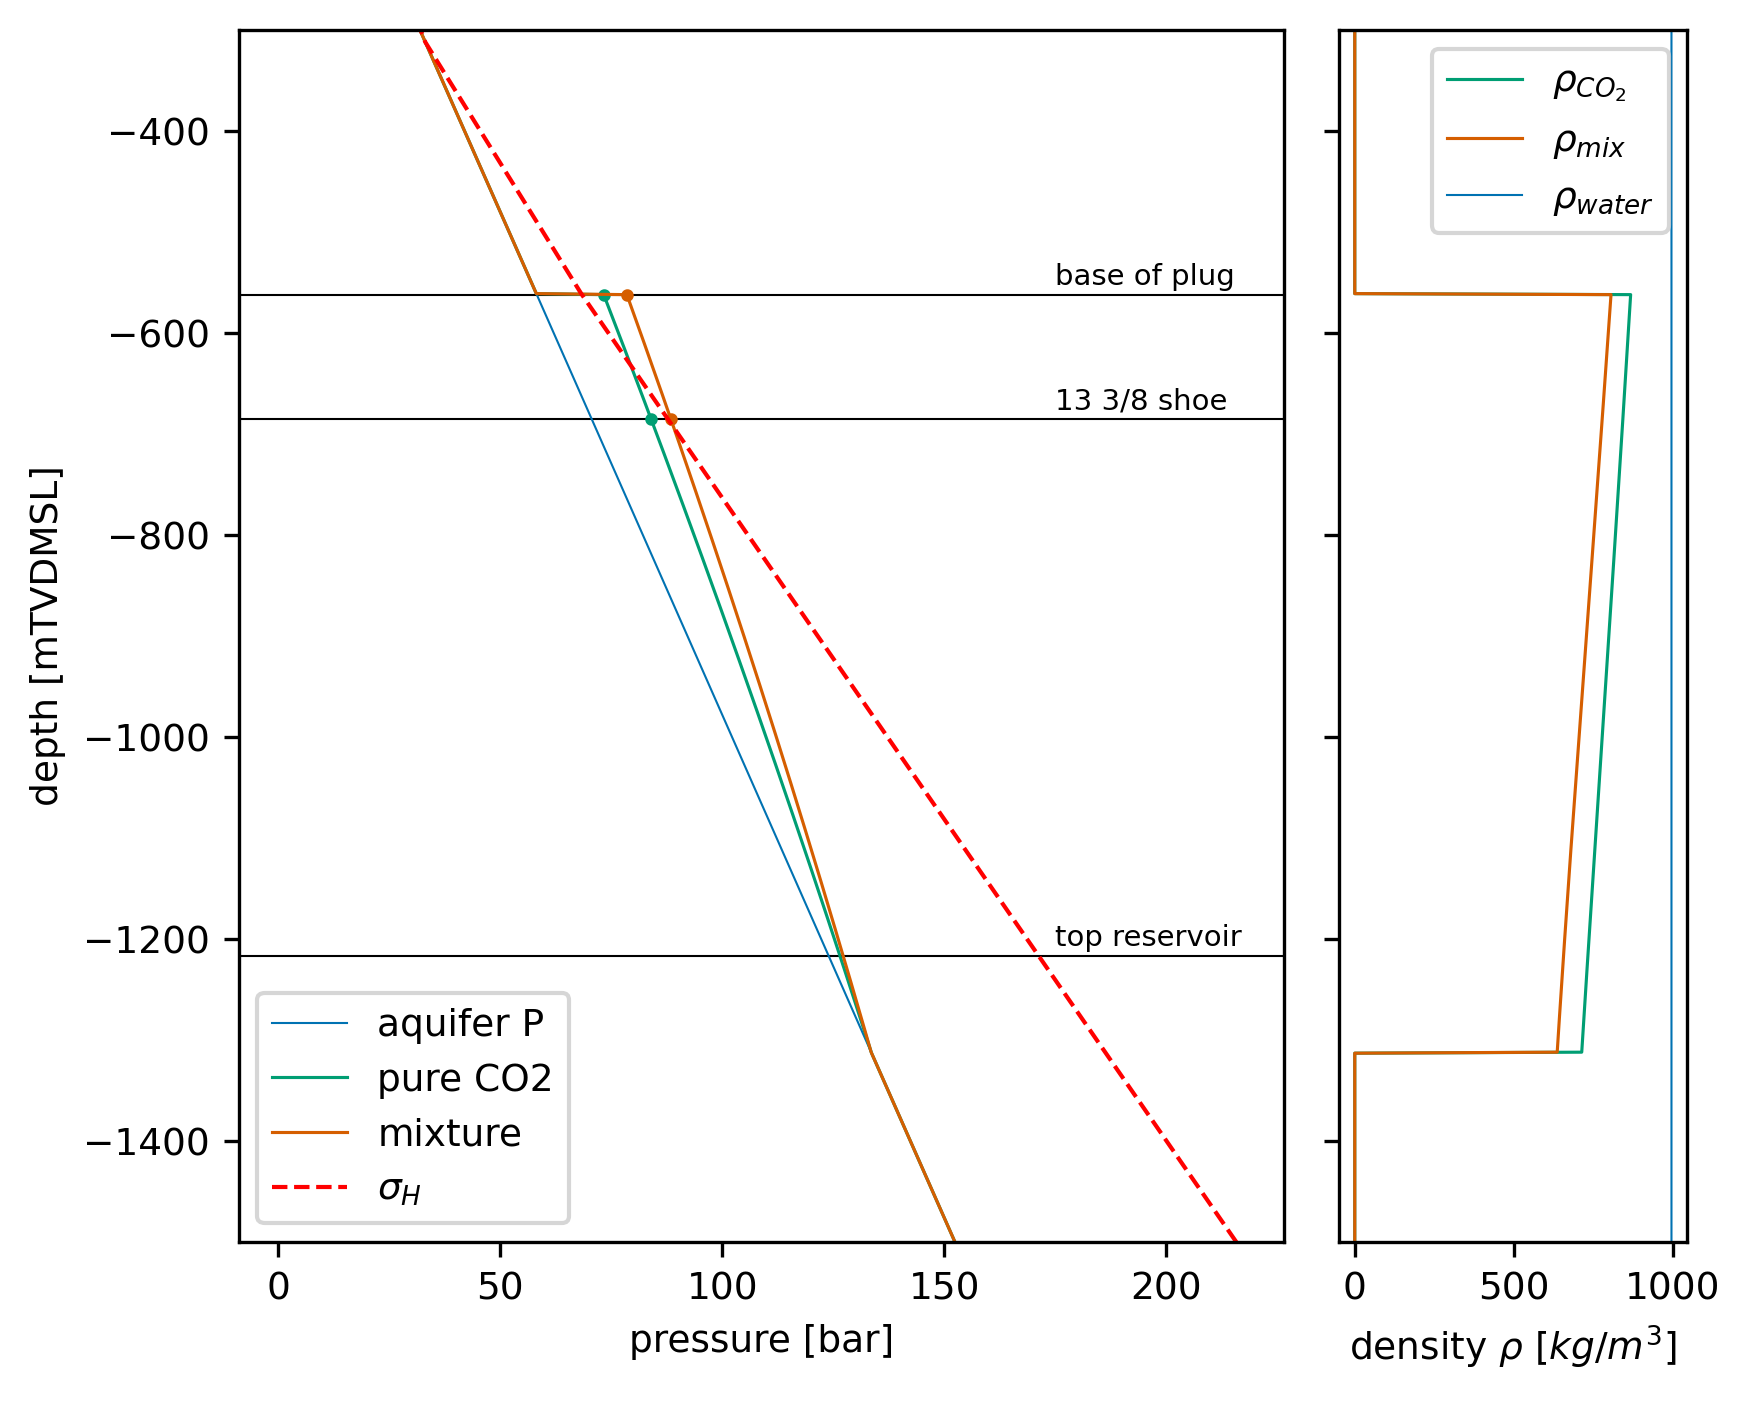

In [6]:
import matplotlib as mpl

style = plt.style.available[13]
plt.style.use(style)

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5.91, 4.74]
mpl.rcParams['lines.linewidth'] = 0.75
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['font.size'] = 9
mpl.rcParams['axes.grid'] = False

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [3, 1]})

df.plot(x='P_aq', y='depth', ax= ax1, label='aquifer P', lw=0.5)
color_H2O = ax1.get_lines()[-1].get_color()

# df.plot(x='P_hyd', y='depth', ax= ax1, label='hydrostatic P', linestyle=':')
# df.plot(x='Sh_min', y='depth', ax= ax1, label='$\sigma_{H}$', linestyle='--', lw=1, c='r')


# df.plot(x='P', y='depth', ax= ax1, label=fluid)

query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')


df.plot(x='P1', y='depth', ax= ax1, label='pure CO2')
color_CO2 = ax1.get_lines()[-1].get_color()
# df.loc[-barrier_Z].plot.scatter('P1', 'depth', c='green')
ax1.scatter(df.loc[-barrier_Z, 'P1'], barrier_Z, color= color_CO2)
ax1.scatter(df.loc[-shoe_Z, 'P1'], shoe_Z, color= color_CO2)

df.plot(x='P2', y='depth', ax= ax1, label='mixture')
color_mix = ax1.get_lines()[-1].get_color()
ax1.scatter(df.loc[-barrier_Z, 'P2'], barrier_Z, color= color_mix)
ax1.scatter(df.loc[-shoe_Z, 'P2'], shoe_Z, color= color_mix)

# ax1.plot(PFT['pressure'], -PFT['depth'], ls=':')

# df.plot(x='Temp', y='depth', ax= ax2, legend=False)
# df.plot(x='rho_g', y='depth', ax= ax2, label=r'$\rho_{CO_2}$')



df.plot(x='rho_g1', y='depth', ax= ax2, label=r'$\rho_{CO_2}$', color=color_CO2)
df.plot(x='rho_g2', y='depth', ax= ax2, label=r'$\rho_{mix}$', color=color_mix)
df['rho_brine'] = rho_brine
df.plot(x='rho_brine', y='depth', ax= ax2, label=r'$\rho_{water}$', c= color_H2O, lw=0.5)




# ax2.plot(rho_g_0, df.depth, '--')
# ax2.plot(rho_g_f, df.depth, '--')
# ax2.plot(PFT['rhog'], -PFT['depth'])


ref_depths = [barrier_Z, shoe_Z, top_SF]
ref_depths_labels = ['base of plug', '13 3/8 shoe', 'top reservoir']

for z_val, z_label in zip(ref_depths, ref_depths_labels):
    ax1.axhline(z_val, color='k', lw = 0.5, zorder=0)
    ax1.annotate(z_label, xy=(175,z_val+10), fontsize=7, label = None)





# ax4.plot(PFT['sgas'], -PFT['depth'])
# sh_min = np.array([[366, 583, 723], [34, 68, 90]])

sh_min = np.array([[-RKB, -Z_sf+RKB, 583, 723], [df.loc[0, 'P_aq'], df.loc[int(-Z_sf), 'P_aq'], 68, 90]])

from scipy import interpolate
x = RKB-sh_min[0]
y = sh_min[1]
sh_func = interpolate.interp1d(x, y, fill_value='extrapolate')
sh = sh_func(df.depth)

# ax1.plot(sh_min[1], RKB-sh_min[0], marker='o', color='k', ms=10, label='Sh_new')
ax1.plot(sh, df.depth, color='r', label='$\sigma_H$', ls='--', lw=1)


ax1.legend(loc='lower left')
ax1.set_ylim(bottom = z.min(), top=-300)
# ax1.set_xlim(left = df.loc[300, 'P_aq'], right=df.loc[int(-z.min()), 'P_aq'])
# ax2.set_xlim(left = df.loc[300, 'Temp'], right=df.loc[int(-z.min()), 'Temp'])


ax1.set_xlabel('pressure [bar]')
# ax2.set_xlabel('Temperature [$\degree$C]')
ax2.set_xlabel(r'density $\rho$ [$kg/m^3$]')
ax1.set_ylabel('depth [mTVDMSL]')
fig.tight_layout()
fig.savefig('Pressure_plot')

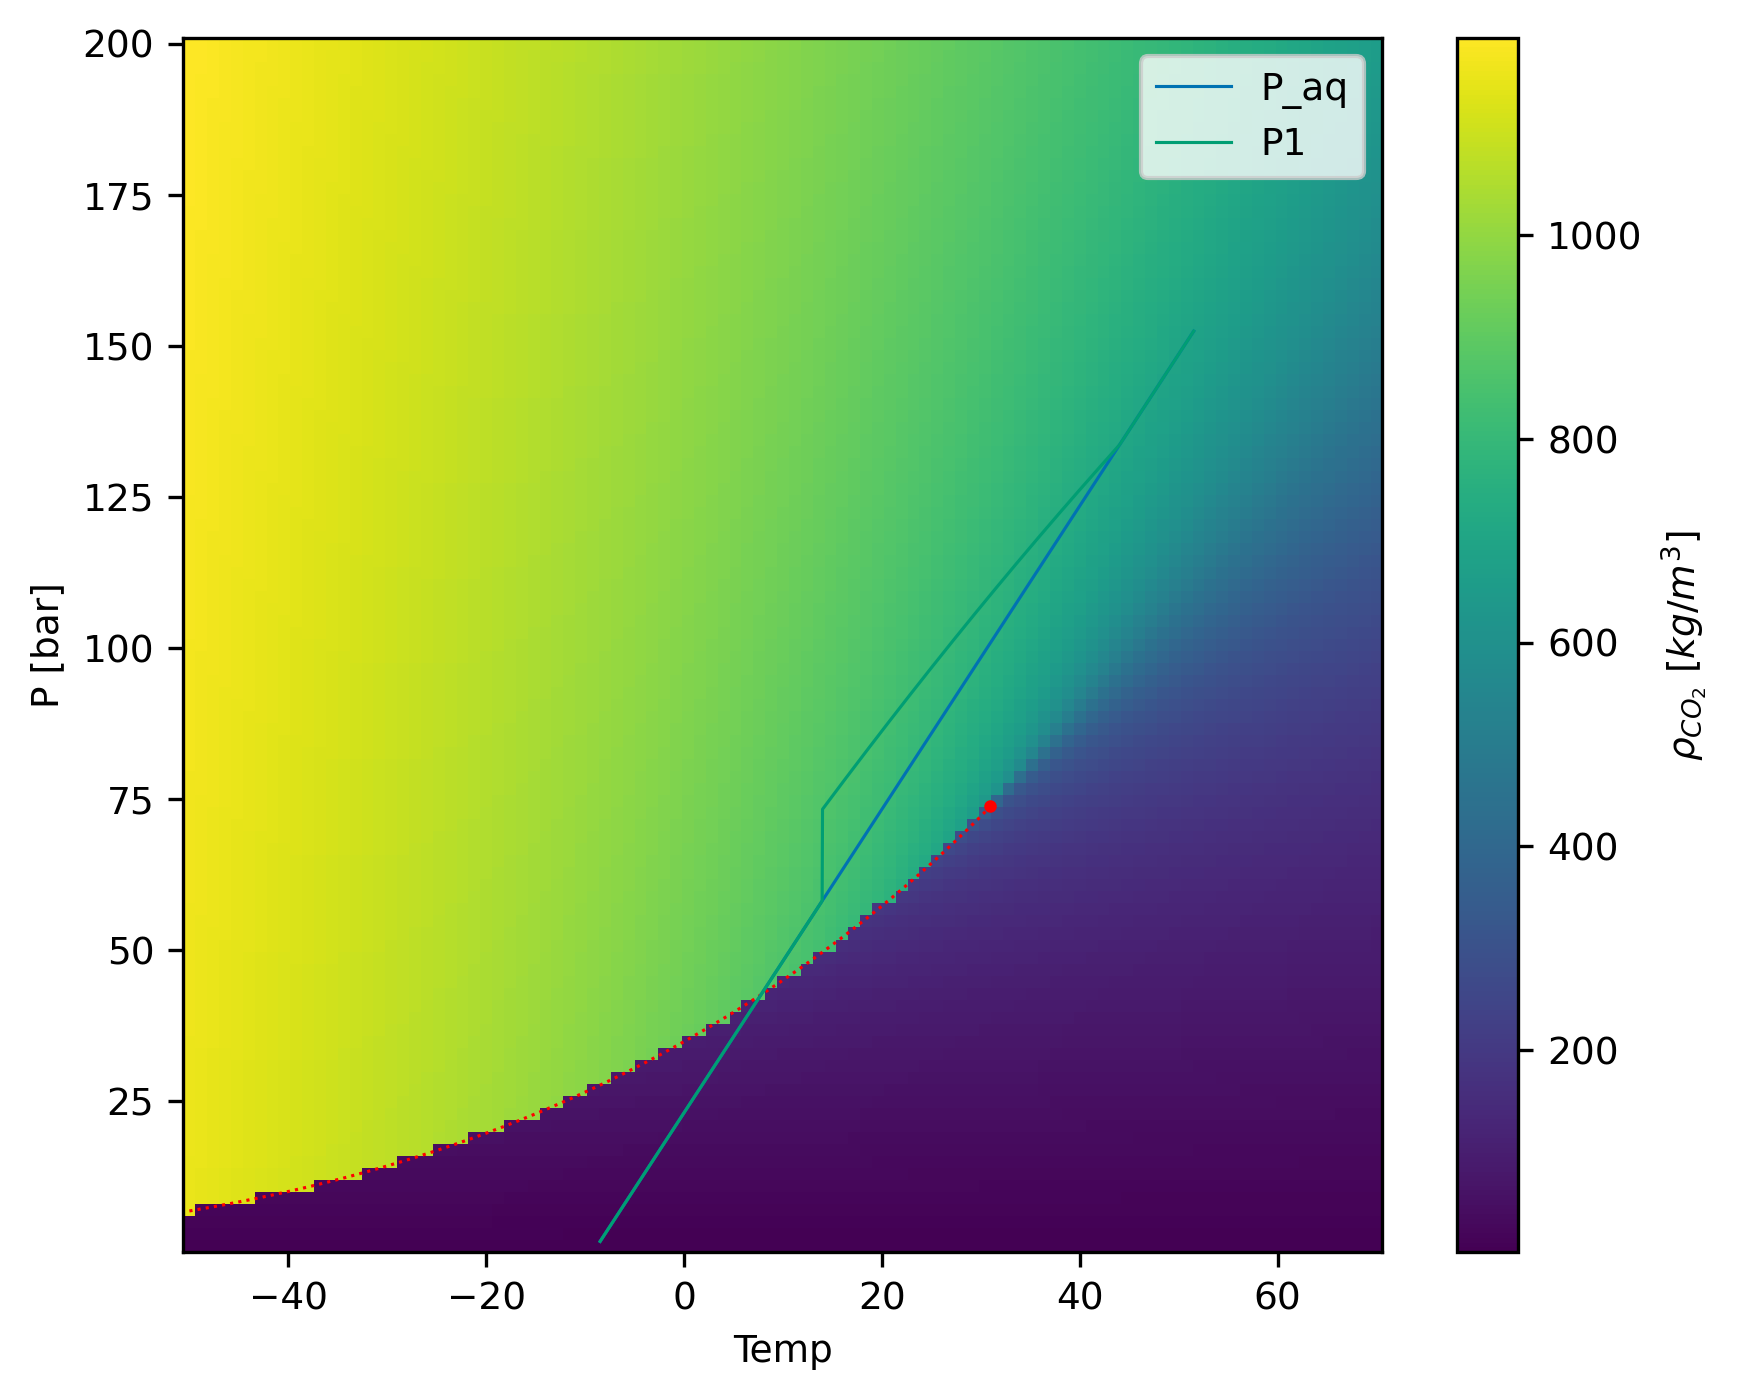

In [98]:
nx, ny = (101, 101)
T = np.linspace(-50, 70, nx)

P = np.linspace(1, 200, ny)
Tv, Pv = np.meshgrid(T, P)



Tv = Tv.flatten()
Pv = Pv.flatten()

density_coolprop = PropsSI("D", "P", Pv*1e5, "T", Tv+273.15, "CO2")



Pcrit = PropsSI('CO2', 'pcrit')
Tcrit = PropsSI('CO2', 'Tcrit')

Tphase = np.linspace(273.15-50, Tcrit, 2000)
Pphase = PropsSI('P','T',Tphase,'Q',0,'CO2')

Tv = Tv.reshape(nx, ny)
Pv = Pv.reshape(nx, ny)
density_coolprop = density_coolprop.reshape(nx, ny)

fig, ax = plt.subplots()

pcm = ax.pcolormesh(Tv, Pv, density_coolprop, shading='nearest')

ax.scatter(Tcrit-273.15, Pcrit/1e5, c='red', label='critical P,T')
ax.plot(Tphase-273.15, Pphase/1e5, c='red', ls=':')
ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('P [bar]')

df.plot(x='Temp', y='P_aq', ax=ax)
df.plot(x='Temp', y='P1', ax=ax)

fig.colorbar(pcm, label = r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.tight_layout()

# fig.savefig('CO2_density.png')


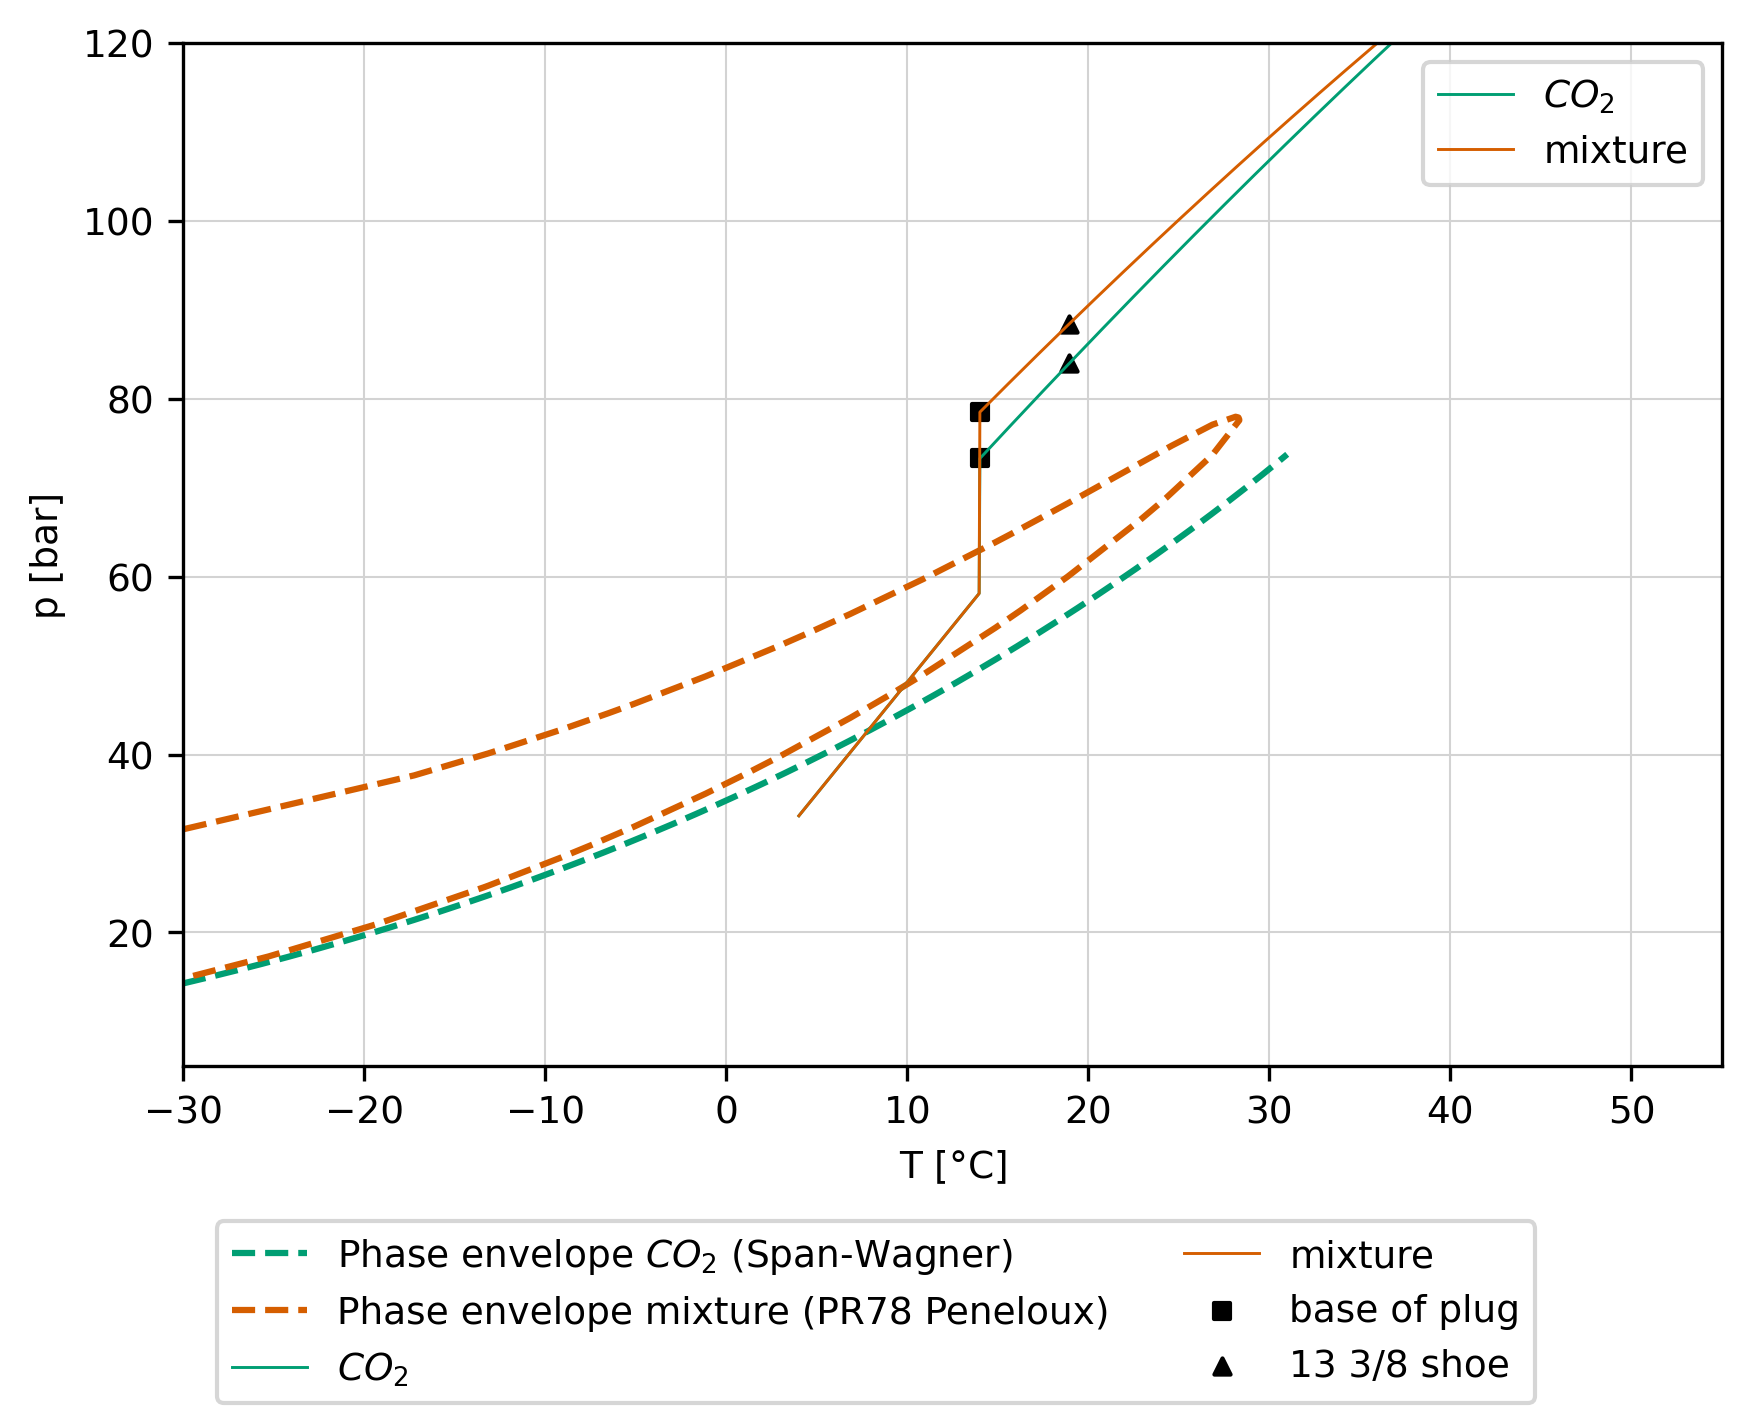

In [110]:
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'lightgray'
mpl.rcParams['grid.linewidth'] = 0.5

HEOS = CP.AbstractState('HEOS', 'CO2&H2&Ar&N2&CH4')
HEOS.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])

HEOS_SRK = CP.AbstractState('HEOS', 'CO2-SRK&H2-SRK&Ar-SRK&N2-SRK&CH4-SRK')
HEOS_SRK.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])



HEOS.build_phase_envelope("dummy")
PE = HEOS.get_phase_envelope_data()


# HEOS_SRK.build_phase_envelope("dummy")
# PE_SRK = HEOS_SRK.get_phase_envelope_data()

PE_T = np.array(PE.T)-273.15
PE_p = np.array(PE.p)/1e5

# PE_T_SRK = np.array(PE_SRK.T)-273.15
# PE_p_SRK = np.array(PE_SRK.p)/1e5

PVTSim_T = [-140.340,-138.719,-137.052,-135.339,-133.576,-131.761,-129.892,-127.965,-125.979,-123.930,-121.815,-119.630,-117.373,-115.038,-112.621,-110.119,-107.526,-104.837,-102.046,-99.148,-96.135,-93.001,-89.739,-86.339,-82.795,-79.095,-75.231,-71.192,-66.966,-62.540,-57.902,-53.039,-47.934,-42.573,-36.941,-31.172,-25.297,-19.354,-13.394,-13.150,-9.150,-7.479,-5.150,-1.150,1.139,2.850,6.850,9.172,10.850,14.850,16.258,18.850,22.850,24.273,26.850,28.329,28.333,28.284,28.128,26.850,24.610,22.850,18.850,15.684,14.850,10.850,6.850,4.729,2.850,-1.150,-5.150,-6.505,-9.150,-13.150,-17.255,-32.715,-48.043,-62.005,-73.024,-75.806,-84.419,-96.327,-108.831,-122.010,-131.639,-139.147,-145.402,-151.192,-155.728,-159.474,-162.046,-162.320,-162.492,-162.610,-162.620,-162.620]

PVTSim_P = [0.010,0.012,0.015,0.019,0.023,0.028,0.035,0.043,0.053,0.065,0.080,0.098,0.121,0.149,0.183,0.225,0.277,0.341,0.419,0.516,0.635,0.782,0.962,1.184,1.457,1.793,2.207,2.716,3.343,4.114,5.063,6.231,7.668,9.437,11.615,14.219,17.304,20.916,25.084,25.267,28.417,29.818,31.858,35.611,37.908,39.699,44.147,46.905,48.985,54.256,56.224,60.018,66.382,68.837,73.718,77.583,77.681,77.916,77.997,77.109,74.753,72.771,68.249,64.771,63.876,59.726,55.828,53.865,52.187,48.802,45.673,44.668,42.788,40.141,37.664,30.318,25.731,23.482,22.812,22.785,23.055,24.343,27.075,32.281,38.726,46.553,56.334,69.991,86.149,106.037,126.076,128.755,130.533,131.816,131.924,131.924]



fig, ax = plt.subplots()
ax.plot(Tphase-273.15, Pphase/1e5, lw=1.5, label=r'Phase envelope $CO_2$ (Span-Wagner)', ls='--', c=color_CO2)

# ax.plot(PE_T, PE_p, '-', label = 'Phase envelope mixture (Coolprop)', lw=1)
# ax.plot(PE_T_SRK, PE_p_SRK, '-', label = 'Phase envelope mixture (Coolprop SRK)', lw=1)

color = ax.get_lines()[-1].get_color()
ax.plot(PVTSim_T, PVTSim_P, '--', label = 'Phase envelope mixture (PR78 Peneloux)', color=color_mix, lw=1.5)


# for x0 in [0.02, 0.2, 0.4, 0.6, 0.8, 0.98]:
#     HEOS.set_mole_fractions([x0, 1 - x0])
#     try:
#         HEOS.build_phase_envelope("dummy")
#         PE = HEOS.get_phase_envelope_data()
#         PELabel = 'Methane, x = ' + str(x0)
#         plt.plot(PE.T, PE.p, '-', label=PELabel)
#     except ValueError as VE:
#         print(VE)

# plt.xlabel('Temperature [K]')
# plt.ylabel('Pressure [Pa]')
# plt.yscale('log')
# plt.title('Phase Envelope for Methane/Ethane Mixtures')
# plt.legend(loc='lower right', shadow=True)
# plt.savefig('methane-ethane.pdf')
# plt.savefig('methane-ethane.png')
# plt.close()

# df[312:].plot(x='Temp', y='P_aq', ax=ax, label='hydrostatic')
df[312:].plot(x='Temp', y='P1', ax=ax, label = r'$CO_2$', c=color_CO2, lw=0.7)
df[312:].plot(x='Temp', y='P2', ax=ax, label = 'mixture', c=color_mix, lw=0.7)

ax.scatter(df.loc[-barrier_Z, 'Temp'], df.loc[-barrier_Z, 'P1'], marker='s', c='k', s=15, label='base of plug')
ax.scatter(df.loc[-barrier_Z, 'Temp'], df.loc[-barrier_Z, 'P2'], marker='s', c='k', s=15)

ax.scatter(df.loc[-shoe_Z, 'Temp'], df.loc[-shoe_Z, 'P1'], marker='^', c='k', s=15, label='13 3/8 shoe')
ax.scatter(df.loc[-shoe_Z, 'Temp'], df.loc[-shoe_Z, 'P2'], marker='^', c='k', s=15)

ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('p [bar]')
ax.set_xlim(-30, 55)
ax.set_ylim(bottom=5, top =120)
# ax.legend()


fig.legend(ncol=2, loc='lower center')

fig.tight_layout(rect=[0, 0.13, 1, 1])

# fig.tight_layout()



fig.savefig('phase_envelope.png')


In [106]:
mpl.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
   

In [ ]:
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt

# Increase the starting pressure a bit, behavior at very low pressure is problematic
CP.set_config_double(CP.PHASE_ENVELOPE_STARTING_PRESSURE_PA, 1e4)

# CP.AbstractState('HEOS', 'CO2&H2&Ar&N2&CH4')
# SRK = CP.AbstractState('SRK','CO2&H2&Ar&N2&CH4')
# # SRK.set_mole_fractions([0.5, 1 - 0.5])
# SRK.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])

# for kij, c in zip([0.0, 0.1],['r','b']):

#     # Set the interaction parameter
#     SRK.set_binary_interaction_double(0, 1, "kij", kij)

#     # Some VLE calculations
#     for p in [1e5, 1e6]:
#         SRK.update(CP.PQ_INPUTS, p, 0)
#         plt.plot(SRK.T(), SRK.p(), '<', color = c)

#         SRK.update(CP.PQ_INPUTS, p, 1)
#         plt.plot(SRK.T(), SRK.p(), '>', color = c)

#     # Phase envelope
#     SRK.build_phase_envelope("")
#     PE = SRK.get_phase_envelope_data()
#     plt.plot(PE.T, PE.p, '-', label = '$k_{ij} = $' + str(kij), color = c)

#     # Critical point
#     pts = SRK.all_critical_points()
#     for pt in pts:
#       plt.plot(pt.T, pt.p, '*', color = c)

# A phase envelope calculated with SRK transformations in a multi-fluid model
# HEOS = CP.AbstractState('HEOS','Methane-SRK&Ethane-SRK')

components = []

components = ['CO2', 'H2', 'Ar', 'N2', 'CH4']
components

components_normal = '&'.join(components)
components_SRK = '&'.join([component+'-SRK' for component in components])
components_PR =  '&'.join([component+'-PengRobinson' for component in components])

HEOS = CP.AbstractState('HEOS', components_normal)
HEOS_SRK = CP.AbstractState('HEOS',components_SRK)
HEOS_PR = CP.AbstractState('HEOS',components_PR)

# HEOS.set_mole_fractions([0.5, 0.5])
HEOS.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])
HEOS_SRK.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])
HEOS_PR.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])

HEOS.build_phase_envelope("none")
HEOS_SRK.build_phase_envelope("none")
HEOS_PR.build_phase_envelope("none")

PE = HEOS.get_phase_envelope_data()
plt.plot(PE.T, PE.p, '-', label = 'multi-fluid')

PE = HEOS_SRK.get_phase_envelope_data()
plt.plot(PE.T, PE.p, '-', label = 'SRK with transformations in multi-fluid')

PE = HEOS_PR.get_phase_envelope_data()
plt.plot(PE.T, PE.p, '-', label = 'PR with transformations in multi-fluid')


plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [Pa]')
plt.yscale('log')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
components_SRK

In [ ]:
HEOS.get_phase_envelope_data()

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [ ]:
HEOS.

In [ ]:
PE.T